## Dependencies and Global variables

In [24]:
import numpy as np
import pandas as pd

import torch

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train', 'train.csv', 'sample_submission.csv']


In [25]:
# Reload latest version of dependencies
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [26]:
# Fast AI Imports
from fastai import *
from fastai.vision import *

In [27]:
# Set batchsize
bs = 64

## DataBunch Setup

In [28]:
path = Path('../input')
path_train = path/'train/train'
path_test = path/'test/test/'
path, path_train, path_test

(PosixPath('../input'),
 PosixPath('../input/train/train'),
 PosixPath('../input/test/test'))

In [29]:
labels_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'sample_submission.csv')
labels_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [30]:
np.random.seed(42)
test = ImageList.from_df(test_df, path=path_test)
data = (
    ImageList.from_df(labels_df, path=path_train)
                     .split_by_rand_pct(0.01)
                     .label_from_df()
                     .add_test(test)
                     .transform(get_transforms(
                         flip_vert = True,
                     ), size = 128)
                     .databunch(path=path, bs = bs).normalize(imagenet_stats)
)

We've used the Fast.ai *DataBlock* API to create a *databunch*. 
1. There are some data augmentations that Fast.ai performs by default. These have been tweaked with
2. The images are resized to 128x128 instead of 32x32, this led to a higher accuracy on the validation set
3. The validation set is set up to be 10% of the training data

In [31]:
data

ImageDataBunch;

Train: LabelList (17325 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,1,1,1,1
Path: ../input/train/train;

Valid: LabelList (175 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,0,0,1,1
Path: ../input/train/train;

Test: LabelList (4000 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: ../input/train/train

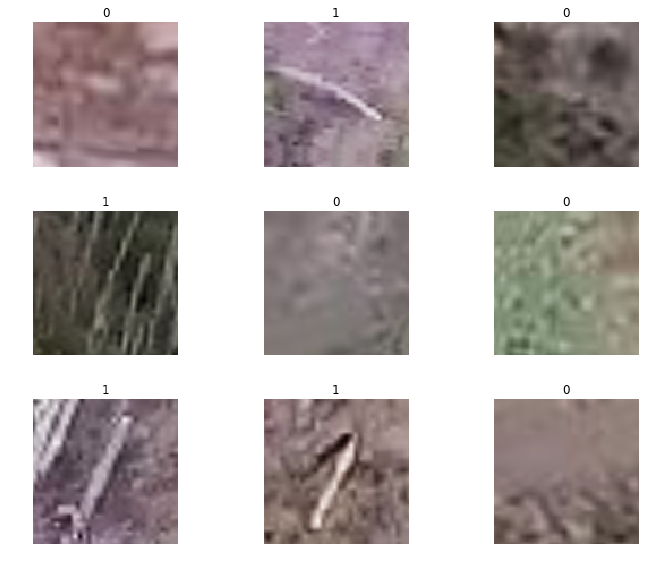

In [32]:
data.show_batch(rows = 3, figsize = (10,8))

The *1* or *0* indicates above the image indicates whether it has a cactus or not. Our validation set is 20% of our train data

In [33]:
# Print classes of our classification problem
data.classes

[0, 1]

## Resnet 101: Training

In [34]:
learn = cnn_learner(data, models.resnet101, metrics = accuracy, model_dir='/tmp/model/')

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


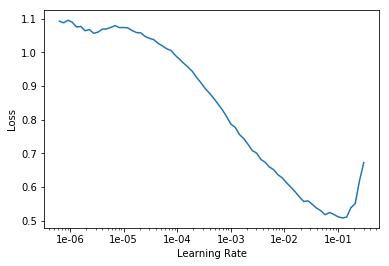

In [36]:
learn.recorder.plot()

From the above plot, we will choose the learning rate as the x-axis value corresponding to the steepest descent (without bumps) of the y-axis value, *Loss*.

In [37]:
lr = 3e-02

In [38]:
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.076033,0.019236,0.988571,00:58
1,0.045004,0.010463,0.994286,00:58
2,0.017607,0.017517,0.994286,00:59
3,0.009532,0.042294,0.994286,00:58


In [39]:
learn.save('resnet-101-1')

An near perfect accuracy but this leads to a leaderboard score of 0.9999. Let's try and improve this with *Densenet 161*

## DenseNet 161 Training

In [40]:
learn = cnn_learner(data, models.densenet161, metrics = accuracy, model_dir='/tmp/model/')

In [41]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


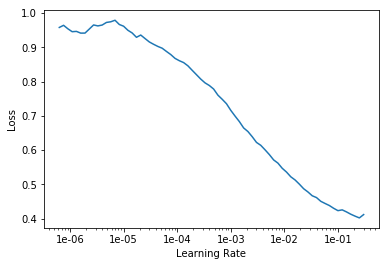

In [42]:
learn.recorder.plot()

In [43]:
lr = 3e-02

In [44]:
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.067953,0.115772,0.971429,01:08
1,0.031001,0.002776,1.000000,01:08
2,0.010554,0.000329,1.000000,01:08
3,0.003941,0.001379,1.000000,01:07


In [45]:
learn.save('densenet-161-1')

## Generating Predictions

### Resnet 101

In [46]:
learn = cnn_learner(data, models.resnet101, metrics = accuracy, model_dir='/tmp/model/')

In [47]:
learn.load('resnet-101-1');

In [48]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [49]:
preds[:, 0]

tensor([3.3515e-07, 9.4164e-07, 1.0000e+00,  ..., 3.3905e-05, 1.5370e-05,
        6.5866e-04])

In [50]:
test_df['has_cactus'] = np.array(preds[:, 0])
test_df.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,3.351506e-07
1,0017242f54ececa4512b4d7937d1e21e.jpg,9.416445e-07
2,001ee6d8564003107853118ab87df407.jpg,1.000000e+00
3,002e175c3c1e060769475f52182583d0.jpg,1.000000e+00
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,1.300603e-04


In [51]:
test_df.to_csv('submission_resnet_101.csv', index = False)

### Densenet 161

In [52]:
learn = cnn_learner(data, models.densenet161, metrics = accuracy, model_dir='/tmp/model/')

In [53]:
learn.load('densenet-161-1');

In [54]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [55]:
preds[:, 0]

tensor([2.4743e-08, 1.2372e-08, 1.0000e+00,  ..., 3.0386e-07, 8.9083e-07,
        4.3679e-06])

In [56]:
test_df['has_cactus'] = np.array(preds[:, 0])
test_df.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,2.474268e-08
1,0017242f54ececa4512b4d7937d1e21e.jpg,1.237202e-08
2,001ee6d8564003107853118ab87df407.jpg,1.000000e+00
3,002e175c3c1e060769475f52182583d0.jpg,1.000000e+00
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,1.908503e-06


In [57]:
test_df.to_csv('submission_densenet_161.csv', index = False)

In [58]:
from IPython.display import FileLinks
FileLinks('.')

./
  submission_densenet_161.csv
  __notebook_source__.ipynb
  submission_resnet_101.csv